In [1]:
import tensorflow as tf
import pandas as pd
from tensorflow.keras import datasets, layers, models, losses, optimizers
from tensorflow.python.client import device_lib 
import tensorflow_hub as hub
from time import time
import numpy as np
import datetime
from PIL import Image
from keras.preprocessing import image
from matplotlib import pyplot as plt

In [2]:
[print(device) for device in device_lib.list_local_devices()];

name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1487533801621282337
xla_global_id: -1

name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5731516416
locality {
  bus_id: 1
  links {
  }
}
incarnation: 16414128549332410266
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3070 Ti, pci bus id: 0000:2d:00.0, compute capability: 8.6"
xla_global_id: 416903419



In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU') 
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
train_df = pd.read_csv("../data/training.csv")
validation_df = pd.read_csv("../data/validation.csv")

train_df.drop("class", axis=1, inplace=True)
validation_df.drop("class", axis=1, inplace=True)

In [5]:
labels = []

for i, row in train_df[train_df.columns[1:]].iterrows():
    labels.append(np.array(row.values).astype(np.float32))
    
train_df['ingredients'] = labels

In [6]:
labels = []

for i, row in validation_df[validation_df.columns[1:]].iterrows():
    labels.append(np.array(row.values).astype(np.float32))
    
validation_df['ingredients'] = labels

In [7]:
train_df = train_df[['path', 'ingredients']]
validation_df = validation_df[['path', 'ingredients']]

In [8]:
train_df.ingredients.iloc[0].shape

(1095,)

In [9]:
IMG_SIZE = (224, 224)
CHANNELS = 3 

BATCH_SIZE = 256 # Big enough to measure an F1-score
AUTOTUNE = tf.data.experimental.AUTOTUNE # Adapt preprocessing and prefetching dynamically
SHUFFLE_BUFFER_SIZE = 1024 # Shuffle the training data by a chunck of 1024 observations

N_LABELS = 1095

In [10]:
def parse_function(filename, label):
    """Function that returns a tuple of normalized image array and labels array.
    Args:
        filename: string representing path to image
        label: 0/1 one-dimensional array of size N_LABELS
    """
    # Read an image from a file
    image_string = tf.io.read_file(filename)
    # Decode it into a dense vector
    image_decoded = tf.image.decode_jpeg(image_string, channels=CHANNELS)
    # Resize it to fixed shape
    image_resized = tf.image.resize(image_decoded, IMG_SIZE)
    # Normalize it from [0, 255] to [0.0, 1.0]
    image_normalized = image_resized / 255.0
    
    return image_normalized, label

In [11]:
def create_dataset(filenames, labels, is_training=True):
    """Load and parse dataset.
    Args:
        filenames: list of image paths
        labels: numpy array of shape (BATCH_SIZE, N_LABELS)
        is_training: boolean to indicate training mode
    """
    
    # Create a first dataset of file paths and labels
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    # Parse and preprocess observations in parallel
    dataset = dataset.map(parse_function, num_parallel_calls=AUTOTUNE)
    
    if is_training == True:
        # This is a small dataset, only load it once, and keep it in memory.
        dataset = dataset.cache()
        # Shuffle the data each buffer size
        dataset = dataset.shuffle(buffer_size=SHUFFLE_BUFFER_SIZE)
        
    # Batch the data for multiple steps
    dataset = dataset.batch(BATCH_SIZE)
    # Fetch batches in the background while the model is training.
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    
    return dataset

In [12]:
train_ds = create_dataset(train_df.path, train_df.ingredients.tolist())
val_ds = create_dataset(validation_df.path, validation_df.ingredients.tolist())

In [13]:
for f, l in train_ds.take(1):
    print("Shape of features array:", f.numpy().shape)
    print("Shape of labels array:", l.numpy().shape)

Shape of features array: (256, 224, 224, 3)
Shape of labels array: (256, 1095)


In [14]:
feature_extractor_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4"
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=(*IMG_SIZE, CHANNELS))

In [15]:
feature_extractor_layer.trainable = False

In [16]:
model = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(2048, activation='relu', name='hidden_layer1'),
    layers.Dense(2048, activation='relu', name='hidden_layer2'),
    layers.Dense(2048, activation='relu', name='hidden_layer3'),
    layers.Dense(N_LABELS, activation='sigmoid', name='output')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 hidden_layer1 (Dense)       (None, 2048)              2623488   
                                                                 
 hidden_layer2 (Dense)       (None, 2048)              4196352   
                                                                 
 hidden_layer3 (Dense)       (None, 2048)              4196352   
                                                                 
 output (Dense)              (None, 1095)              2243655   
                                                                 
Total params: 15,517,831
Trainable params: 13,259,847
Non-trainable params: 2,257,984
_________________________________________________________________


In [17]:
@tf.function
def macro_soft_f1(y, y_hat):
    """Compute the macro soft F1-score as a cost (average 1 - soft-F1 across all labels).
    Use probability values instead of binary predictions.
    
    Args:
        y (int32 Tensor): targets array of shape (BATCH_SIZE, N_LABELS)
        y_hat (float32 Tensor): probability matrix from forward propagation of shape (BATCH_SIZE, N_LABELS)
        
    Returns:
        cost (scalar Tensor): value of the cost function for the batch
    """
    y = tf.cast(y, tf.float32)
    y_hat = tf.cast(y_hat, tf.float32)
    tp = tf.reduce_sum(y_hat * y, axis=0)
    fp = tf.reduce_sum(y_hat * (1 - y), axis=0)
    fn = tf.reduce_sum((1 - y_hat) * y, axis=0)
    soft_f1 = 2*tp / (2*tp + fn + fp + 1e-16)
    cost = 1 - soft_f1 # reduce 1 - soft-f1 in order to increase soft-f1
    macro_cost = tf.reduce_mean(cost) # average on all labels
    return macro_cost

In [18]:
@tf.function
def macro_f1(y, y_hat, thresh=0.5):
    """Compute the macro F1-score on a batch of observations (average F1 across labels)
    
    Args:
        y (int32 Tensor): labels array of shape (BATCH_SIZE, N_LABELS)
        y_hat (float32 Tensor): probability matrix from forward propagation of shape (BATCH_SIZE, N_LABELS)
        thresh: probability value above which we predict positive
        
    Returns:
        macro_f1 (scalar Tensor): value of macro F1 for the batch
    """
    y_pred = tf.cast(tf.greater(y_hat, thresh), tf.float32)
    tp = tf.cast(tf.math.count_nonzero(y_pred * y, axis=0), tf.float32)
    fp = tf.cast(tf.math.count_nonzero(y_pred * (1 - y), axis=0), tf.float32)
    fn = tf.cast(tf.math.count_nonzero((1 - y_pred) * y, axis=0), tf.float32)
    f1 = 2*tp / (2*tp + fn + fp + 1e-16)
    macro_f1 = tf.reduce_mean(f1)
    return macro_f1

In [19]:
LR = 1e-5 # Keep it small when transfer learning
EPOCHS = 1000

In [20]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
    loss=tf.keras.metrics.binary_crossentropy,
    metrics=[macro_f1])

In [21]:
start = time()
history = model.fit(train_ds,
                    epochs=EPOCHS,
                    validation_data=val_ds)
print('\nTraining took {}'.format(datetime.timedelta(seconds=time()-start)))

Epoch 1/1000
14/14 [==============================] - 8s 253ms/step - loss: 0.1733 - macro_f1: 0.0026 - val_loss: 0.0544 - val_macro_f1: 0.0014
Epoch 2/1000
14/14 [==============================] - 2s 170ms/step - loss: 0.0396 - macro_f1: 0.0015 - val_loss: 0.0284 - val_macro_f1: 0.0012
Epoch 3/1000
14/14 [==============================] - 2s 161ms/step - loss: 0.0255 - macro_f1: 8.0401e-04 - val_loss: 0.0245 - val_macro_f1: 8.8885e-04
Epoch 4/1000
14/14 [==============================] - 2s 162ms/step - loss: 0.0237 - macro_f1: 9.3478e-04 - val_loss: 0.0237 - val_macro_f1: 7.6073e-04
Epoch 5/1000
14/14 [==============================] - 2s 165ms/step - loss: 0.0230 - macro_f1: 0.0017 - val_loss: 0.0232 - val_macro_f1: 0.0019
Epoch 6/1000
14/14 [==============================] - 2s 169ms/step - loss: 0.0226 - macro_f1: 0.0027 - val_loss: 0.0229 - val_macro_f1: 0.0025
Epoch 7/1000
14/14 [==============================] - 2s 161ms/step - loss: 0.0221 - macro_f1: 0.0031 - val_loss: 0.0226

14/14 [==============================] - 2s 168ms/step - loss: 6.2353e-04 - macro_f1: 0.1734 - val_loss: 0.0432 - val_macro_f1: 0.0266
Epoch 58/1000
14/14 [==============================] - 2s 164ms/step - loss: 5.4972e-04 - macro_f1: 0.1740 - val_loss: 0.0439 - val_macro_f1: 0.0269
Epoch 59/1000
14/14 [==============================] - 2s 164ms/step - loss: 4.8242e-04 - macro_f1: 0.1738 - val_loss: 0.0447 - val_macro_f1: 0.0261
Epoch 60/1000
14/14 [==============================] - 2s 165ms/step - loss: 4.3339e-04 - macro_f1: 0.1754 - val_loss: 0.0453 - val_macro_f1: 0.0267
Epoch 61/1000
14/14 [==============================] - 2s 164ms/step - loss: 3.9448e-04 - macro_f1: 0.1765 - val_loss: 0.0468 - val_macro_f1: 0.0263
Epoch 62/1000
14/14 [==============================] - 2s 165ms/step - loss: 4.2405e-04 - macro_f1: 0.1747 - val_loss: 0.0462 - val_macro_f1: 0.0263
Epoch 63/1000
14/14 [==============================] - 2s 164ms/step - loss: 3.6971e-04 - macro_f1: 0.1750 - val_loss: 0

Epoch 112/1000
14/14 [==============================] - 2s 162ms/step - loss: 5.5388e-05 - macro_f1: 0.1741 - val_loss: 0.0648 - val_macro_f1: 0.0255
Epoch 113/1000
14/14 [==============================] - 2s 164ms/step - loss: 5.3557e-05 - macro_f1: 0.1752 - val_loss: 0.0645 - val_macro_f1: 0.0258
Epoch 114/1000
14/14 [==============================] - 2s 162ms/step - loss: 5.0965e-05 - macro_f1: 0.1762 - val_loss: 0.0644 - val_macro_f1: 0.0276
Epoch 115/1000
14/14 [==============================] - 2s 166ms/step - loss: 6.0381e-05 - macro_f1: 0.1755 - val_loss: 0.0662 - val_macro_f1: 0.0264
Epoch 116/1000
14/14 [==============================] - 2s 173ms/step - loss: 9.3584e-05 - macro_f1: 0.1750 - val_loss: 0.0643 - val_macro_f1: 0.0270
Epoch 117/1000
14/14 [==============================] - 3s 182ms/step - loss: 7.8288e-05 - macro_f1: 0.1756 - val_loss: 0.0649 - val_macro_f1: 0.0257
Epoch 118/1000
14/14 [==============================] - 2s 170ms/step - loss: 6.3413e-05 - macro_f1:

Epoch 167/1000
14/14 [==============================] - 2s 171ms/step - loss: 3.5091e-05 - macro_f1: 0.1755 - val_loss: 0.0699 - val_macro_f1: 0.0289
Epoch 168/1000
14/14 [==============================] - 2s 164ms/step - loss: 3.1323e-05 - macro_f1: 0.1757 - val_loss: 0.0699 - val_macro_f1: 0.0264
Epoch 169/1000
14/14 [==============================] - 2s 161ms/step - loss: 3.0859e-05 - macro_f1: 0.1755 - val_loss: 0.0700 - val_macro_f1: 0.0271
Epoch 170/1000
14/14 [==============================] - 2s 161ms/step - loss: 2.9578e-05 - macro_f1: 0.1764 - val_loss: 0.0695 - val_macro_f1: 0.0271
Epoch 171/1000
14/14 [==============================] - 2s 165ms/step - loss: 3.3738e-05 - macro_f1: 0.1750 - val_loss: 0.0706 - val_macro_f1: 0.0262
Epoch 172/1000
14/14 [==============================] - 2s 162ms/step - loss: 3.3759e-05 - macro_f1: 0.1749 - val_loss: 0.0712 - val_macro_f1: 0.0257
Epoch 173/1000
14/14 [==============================] - 2s 162ms/step - loss: 2.9562e-05 - macro_f1:

14/14 [==============================] - 2s 161ms/step - loss: 2.0896e-05 - macro_f1: 0.1747 - val_loss: 0.0751 - val_macro_f1: 0.0271
Epoch 222/1000
14/14 [==============================] - 2s 161ms/step - loss: 3.4081e-05 - macro_f1: 0.1759 - val_loss: 0.0744 - val_macro_f1: 0.0271
Epoch 223/1000
14/14 [==============================] - 2s 161ms/step - loss: 2.9894e-05 - macro_f1: 0.1769 - val_loss: 0.0756 - val_macro_f1: 0.0264
Epoch 224/1000
14/14 [==============================] - 2s 161ms/step - loss: 3.2311e-05 - macro_f1: 0.1747 - val_loss: 0.0751 - val_macro_f1: 0.0263
Epoch 225/1000
14/14 [==============================] - 2s 161ms/step - loss: 2.5024e-05 - macro_f1: 0.1741 - val_loss: 0.0753 - val_macro_f1: 0.0261
Epoch 226/1000
14/14 [==============================] - 2s 161ms/step - loss: 2.4216e-05 - macro_f1: 0.1753 - val_loss: 0.0754 - val_macro_f1: 0.0266
Epoch 227/1000
14/14 [==============================] - 2s 162ms/step - loss: 2.2878e-05 - macro_f1: 0.1765 - val_l

Epoch 276/1000
14/14 [==============================] - 2s 162ms/step - loss: 1.6170e-05 - macro_f1: 0.1746 - val_loss: 0.0811 - val_macro_f1: 0.0266
Epoch 277/1000
14/14 [==============================] - 2s 160ms/step - loss: 2.2588e-05 - macro_f1: 0.1737 - val_loss: 0.0797 - val_macro_f1: 0.0265
Epoch 278/1000
14/14 [==============================] - 2s 160ms/step - loss: 2.0849e-05 - macro_f1: 0.1749 - val_loss: 0.0797 - val_macro_f1: 0.0260
Epoch 279/1000
14/14 [==============================] - 2s 160ms/step - loss: 1.8454e-05 - macro_f1: 0.1773 - val_loss: 0.0813 - val_macro_f1: 0.0264
Epoch 280/1000
14/14 [==============================] - 2s 160ms/step - loss: 2.8106e-05 - macro_f1: 0.1751 - val_loss: 0.0791 - val_macro_f1: 0.0274
Epoch 281/1000
14/14 [==============================] - 2s 161ms/step - loss: 1.8567e-05 - macro_f1: 0.1766 - val_loss: 0.0808 - val_macro_f1: 0.0272
Epoch 282/1000
14/14 [==============================] - 2s 162ms/step - loss: 1.9261e-05 - macro_f1:

Epoch 331/1000
14/14 [==============================] - 2s 161ms/step - loss: 3.2830e-05 - macro_f1: 0.1753 - val_loss: 0.0740 - val_macro_f1: 0.0265
Epoch 332/1000
14/14 [==============================] - 2s 161ms/step - loss: 2.8838e-05 - macro_f1: 0.1744 - val_loss: 0.0734 - val_macro_f1: 0.0263
Epoch 333/1000
14/14 [==============================] - 2s 161ms/step - loss: 3.0975e-05 - macro_f1: 0.1762 - val_loss: 0.0739 - val_macro_f1: 0.0268
Epoch 334/1000
14/14 [==============================] - 2s 160ms/step - loss: 2.9524e-05 - macro_f1: 0.1743 - val_loss: 0.0736 - val_macro_f1: 0.0273
Epoch 335/1000
14/14 [==============================] - 2s 160ms/step - loss: 2.5904e-05 - macro_f1: 0.1768 - val_loss: 0.0748 - val_macro_f1: 0.0265
Epoch 336/1000
14/14 [==============================] - 2s 160ms/step - loss: 2.6022e-05 - macro_f1: 0.1749 - val_loss: 0.0740 - val_macro_f1: 0.0279
Epoch 337/1000
14/14 [==============================] - 2s 160ms/step - loss: 2.7369e-05 - macro_f1:

14/14 [==============================] - 2s 161ms/step - loss: 1.9935e-05 - macro_f1: 0.1759 - val_loss: 0.0832 - val_macro_f1: 0.0260
Epoch 386/1000
14/14 [==============================] - 2s 161ms/step - loss: 2.3188e-05 - macro_f1: 0.1750 - val_loss: 0.0804 - val_macro_f1: 0.0287
Epoch 387/1000
14/14 [==============================] - 2s 162ms/step - loss: 2.6978e-05 - macro_f1: 0.1753 - val_loss: 0.0794 - val_macro_f1: 0.0258
Epoch 388/1000
14/14 [==============================] - 2s 162ms/step - loss: 2.0068e-05 - macro_f1: 0.1756 - val_loss: 0.0796 - val_macro_f1: 0.0282
Epoch 389/1000
14/14 [==============================] - 2s 162ms/step - loss: 2.3137e-05 - macro_f1: 0.1757 - val_loss: 0.0808 - val_macro_f1: 0.0259
Epoch 390/1000
14/14 [==============================] - 2s 161ms/step - loss: 2.0860e-05 - macro_f1: 0.1757 - val_loss: 0.0810 - val_macro_f1: 0.0275
Epoch 391/1000
14/14 [==============================] - 2s 161ms/step - loss: 2.1144e-05 - macro_f1: 0.1756 - val_l

Epoch 440/1000
14/14 [==============================] - 2s 161ms/step - loss: 2.0549e-05 - macro_f1: 0.1745 - val_loss: 0.0805 - val_macro_f1: 0.0279
Epoch 441/1000
14/14 [==============================] - 2s 161ms/step - loss: 1.8236e-05 - macro_f1: 0.1742 - val_loss: 0.0802 - val_macro_f1: 0.0282
Epoch 442/1000
14/14 [==============================] - 2s 161ms/step - loss: 1.9398e-05 - macro_f1: 0.1754 - val_loss: 0.0804 - val_macro_f1: 0.0290
Epoch 443/1000
14/14 [==============================] - 2s 161ms/step - loss: 2.0393e-05 - macro_f1: 0.1755 - val_loss: 0.0824 - val_macro_f1: 0.0282
Epoch 444/1000
14/14 [==============================] - 2s 162ms/step - loss: 2.0562e-05 - macro_f1: 0.1768 - val_loss: 0.0809 - val_macro_f1: 0.0277
Epoch 445/1000
14/14 [==============================] - 2s 161ms/step - loss: 2.0646e-05 - macro_f1: 0.1751 - val_loss: 0.0812 - val_macro_f1: 0.0275
Epoch 446/1000
14/14 [==============================] - 2s 161ms/step - loss: 1.8070e-05 - macro_f1:

14/14 [==============================] - 2s 160ms/step - loss: 1.4787e-05 - macro_f1: 0.1738 - val_loss: 0.0868 - val_macro_f1: 0.0287
Epoch 495/1000
14/14 [==============================] - 2s 161ms/step - loss: 1.5038e-05 - macro_f1: 0.1737 - val_loss: 0.0875 - val_macro_f1: 0.0280
Epoch 496/1000
14/14 [==============================] - 2s 161ms/step - loss: 1.1991e-05 - macro_f1: 0.1758 - val_loss: 0.0877 - val_macro_f1: 0.0276
Epoch 497/1000
14/14 [==============================] - 2s 161ms/step - loss: 1.4529e-05 - macro_f1: 0.1758 - val_loss: 0.0883 - val_macro_f1: 0.0273
Epoch 498/1000
14/14 [==============================] - 2s 160ms/step - loss: 1.2545e-05 - macro_f1: 0.1754 - val_loss: 0.0881 - val_macro_f1: 0.0272
Epoch 499/1000
14/14 [==============================] - 2s 161ms/step - loss: 1.2643e-05 - macro_f1: 0.1750 - val_loss: 0.0890 - val_macro_f1: 0.0273
Epoch 500/1000
14/14 [==============================] - 2s 161ms/step - loss: 1.1318e-05 - macro_f1: 0.1759 - val_l

Epoch 549/1000
14/14 [==============================] - 2s 160ms/step - loss: 0.0013 - macro_f1: 0.1661 - val_loss: 0.0515 - val_macro_f1: 0.0282
Epoch 550/1000
14/14 [==============================] - 2s 161ms/step - loss: 4.8265e-04 - macro_f1: 0.1721 - val_loss: 0.0560 - val_macro_f1: 0.0272
Epoch 551/1000
14/14 [==============================] - 2s 162ms/step - loss: 2.1610e-04 - macro_f1: 0.1758 - val_loss: 0.0599 - val_macro_f1: 0.0285
Epoch 552/1000
14/14 [==============================] - 2s 161ms/step - loss: 1.0824e-04 - macro_f1: 0.1755 - val_loss: 0.0642 - val_macro_f1: 0.0278
Epoch 553/1000
14/14 [==============================] - 2s 160ms/step - loss: 5.7245e-05 - macro_f1: 0.1742 - val_loss: 0.0665 - val_macro_f1: 0.0267
Epoch 554/1000
14/14 [==============================] - 2s 160ms/step - loss: 3.3349e-05 - macro_f1: 0.1760 - val_loss: 0.0687 - val_macro_f1: 0.0273
Epoch 555/1000
14/14 [==============================] - 2s 161ms/step - loss: 2.6020e-05 - macro_f1: 0.1

14/14 [==============================] - 2s 161ms/step - loss: 1.0044e-05 - macro_f1: 0.1755 - val_loss: 0.0884 - val_macro_f1: 0.0278
Epoch 604/1000
14/14 [==============================] - 2s 160ms/step - loss: 1.0549e-05 - macro_f1: 0.1760 - val_loss: 0.0885 - val_macro_f1: 0.0279
Epoch 605/1000
14/14 [==============================] - 2s 161ms/step - loss: 1.7121e-05 - macro_f1: 0.1750 - val_loss: 0.0882 - val_macro_f1: 0.0267
Epoch 606/1000
14/14 [==============================] - 2s 161ms/step - loss: 1.5583e-05 - macro_f1: 0.1757 - val_loss: 0.0872 - val_macro_f1: 0.0286
Epoch 607/1000
14/14 [==============================] - 2s 162ms/step - loss: 1.1833e-05 - macro_f1: 0.1766 - val_loss: 0.0873 - val_macro_f1: 0.0290
Epoch 608/1000
14/14 [==============================] - 2s 161ms/step - loss: 1.1206e-05 - macro_f1: 0.1757 - val_loss: 0.0885 - val_macro_f1: 0.0277
Epoch 609/1000
14/14 [==============================] - 2s 161ms/step - loss: 1.4647e-05 - macro_f1: 0.1739 - val_l

Epoch 658/1000
14/14 [==============================] - 2s 162ms/step - loss: 9.6088e-06 - macro_f1: 0.1749 - val_loss: 0.0939 - val_macro_f1: 0.0266
Epoch 659/1000
14/14 [==============================] - 2s 163ms/step - loss: 1.0038e-05 - macro_f1: 0.1745 - val_loss: 0.0941 - val_macro_f1: 0.0269
Epoch 660/1000
14/14 [==============================] - 2s 161ms/step - loss: 1.3643e-05 - macro_f1: 0.1766 - val_loss: 0.0930 - val_macro_f1: 0.0273
Epoch 661/1000
14/14 [==============================] - 2s 161ms/step - loss: 1.0780e-05 - macro_f1: 0.1770 - val_loss: 0.0930 - val_macro_f1: 0.0278
Epoch 662/1000
14/14 [==============================] - 2s 161ms/step - loss: 1.1130e-05 - macro_f1: 0.1749 - val_loss: 0.0932 - val_macro_f1: 0.0260
Epoch 663/1000
14/14 [==============================] - 2s 160ms/step - loss: 9.6882e-06 - macro_f1: 0.1755 - val_loss: 0.0933 - val_macro_f1: 0.0275
Epoch 664/1000
14/14 [==============================] - 2s 161ms/step - loss: 9.1915e-06 - macro_f1:

14/14 [==============================] - 2s 161ms/step - loss: 8.4606e-06 - macro_f1: 0.1770 - val_loss: 0.0981 - val_macro_f1: 0.0266
Epoch 713/1000
14/14 [==============================] - 2s 162ms/step - loss: 7.6884e-06 - macro_f1: 0.1766 - val_loss: 0.0986 - val_macro_f1: 0.0268
Epoch 714/1000
14/14 [==============================] - 2s 161ms/step - loss: 7.9020e-06 - macro_f1: 0.1760 - val_loss: 0.0986 - val_macro_f1: 0.0268
Epoch 715/1000
14/14 [==============================] - 2s 162ms/step - loss: 7.6991e-06 - macro_f1: 0.1768 - val_loss: 0.0989 - val_macro_f1: 0.0275
Epoch 716/1000
14/14 [==============================] - 2s 163ms/step - loss: 7.4088e-06 - macro_f1: 0.1761 - val_loss: 0.0992 - val_macro_f1: 0.0279
Epoch 717/1000
14/14 [==============================] - 2s 171ms/step - loss: 8.6199e-06 - macro_f1: 0.1745 - val_loss: 0.0992 - val_macro_f1: 0.0276
Epoch 718/1000
14/14 [==============================] - 2s 164ms/step - loss: 8.2334e-06 - macro_f1: 0.1749 - val_l

Epoch 767/1000
14/14 [==============================] - 2s 162ms/step - loss: 8.5241e-06 - macro_f1: 0.1776 - val_loss: 0.1019 - val_macro_f1: 0.0273
Epoch 768/1000
14/14 [==============================] - 2s 162ms/step - loss: 9.1428e-06 - macro_f1: 0.1773 - val_loss: 0.1017 - val_macro_f1: 0.0272
Epoch 769/1000
14/14 [==============================] - 2s 162ms/step - loss: 7.4622e-06 - macro_f1: 0.1753 - val_loss: 0.1018 - val_macro_f1: 0.0266
Epoch 770/1000
14/14 [==============================] - 2s 162ms/step - loss: 8.4132e-06 - macro_f1: 0.1751 - val_loss: 0.1021 - val_macro_f1: 0.0267
Epoch 771/1000
14/14 [==============================] - 2s 162ms/step - loss: 7.4694e-06 - macro_f1: 0.1753 - val_loss: 0.1022 - val_macro_f1: 0.0260
Epoch 772/1000
14/14 [==============================] - 2s 163ms/step - loss: 8.1762e-06 - macro_f1: 0.1744 - val_loss: 0.1021 - val_macro_f1: 0.0259
Epoch 773/1000
14/14 [==============================] - 2s 162ms/step - loss: 9.1795e-06 - macro_f1:

Epoch 822/1000
14/14 [==============================] - 3s 182ms/step - loss: 1.0724e-05 - macro_f1: 0.1768 - val_loss: 0.0883 - val_macro_f1: 0.0286
Epoch 823/1000
14/14 [==============================] - 2s 168ms/step - loss: 9.5389e-06 - macro_f1: 0.1752 - val_loss: 0.0889 - val_macro_f1: 0.0266
Epoch 824/1000
14/14 [==============================] - 2s 169ms/step - loss: 1.0116e-05 - macro_f1: 0.1773 - val_loss: 0.0888 - val_macro_f1: 0.0281
Epoch 825/1000
14/14 [==============================] - 2s 165ms/step - loss: 8.6145e-06 - macro_f1: 0.1758 - val_loss: 0.0894 - val_macro_f1: 0.0280
Epoch 826/1000
14/14 [==============================] - 2s 168ms/step - loss: 8.9585e-06 - macro_f1: 0.1766 - val_loss: 0.0897 - val_macro_f1: 0.0287
Epoch 827/1000
14/14 [==============================] - 2s 170ms/step - loss: 8.8817e-06 - macro_f1: 0.1753 - val_loss: 0.0901 - val_macro_f1: 0.0272
Epoch 828/1000
14/14 [==============================] - 2s 176ms/step - loss: 8.7942e-06 - macro_f1:

14/14 [==============================] - 2s 161ms/step - loss: 7.4725e-06 - macro_f1: 0.1752 - val_loss: 0.0954 - val_macro_f1: 0.0279
Epoch 877/1000
14/14 [==============================] - 2s 160ms/step - loss: 7.7713e-06 - macro_f1: 0.1755 - val_loss: 0.0957 - val_macro_f1: 0.0280
Epoch 878/1000
14/14 [==============================] - 2s 160ms/step - loss: 7.2136e-06 - macro_f1: 0.1764 - val_loss: 0.0959 - val_macro_f1: 0.0269
Epoch 879/1000
14/14 [==============================] - 2s 161ms/step - loss: 7.7606e-06 - macro_f1: 0.1765 - val_loss: 0.0961 - val_macro_f1: 0.0278
Epoch 880/1000
14/14 [==============================] - 2s 161ms/step - loss: 7.2693e-06 - macro_f1: 0.1756 - val_loss: 0.0965 - val_macro_f1: 0.0278
Epoch 881/1000
14/14 [==============================] - 2s 162ms/step - loss: 7.0940e-06 - macro_f1: 0.1752 - val_loss: 0.0966 - val_macro_f1: 0.0284
Epoch 882/1000
14/14 [==============================] - 2s 160ms/step - loss: 7.9195e-06 - macro_f1: 0.1768 - val_l

Epoch 931/1000
14/14 [==============================] - 2s 162ms/step - loss: 4.3809e-05 - macro_f1: 0.1733 - val_loss: 0.0714 - val_macro_f1: 0.0294
Epoch 932/1000
14/14 [==============================] - 2s 162ms/step - loss: 2.3399e-05 - macro_f1: 0.1747 - val_loss: 0.0740 - val_macro_f1: 0.0282
Epoch 933/1000
14/14 [==============================] - 2s 162ms/step - loss: 1.6733e-05 - macro_f1: 0.1753 - val_loss: 0.0756 - val_macro_f1: 0.0289
Epoch 934/1000
14/14 [==============================] - 2s 162ms/step - loss: 1.2914e-05 - macro_f1: 0.1771 - val_loss: 0.0770 - val_macro_f1: 0.0280
Epoch 935/1000
14/14 [==============================] - 2s 162ms/step - loss: 1.2174e-05 - macro_f1: 0.1742 - val_loss: 0.0781 - val_macro_f1: 0.0283
Epoch 936/1000
14/14 [==============================] - 2s 163ms/step - loss: 1.1533e-05 - macro_f1: 0.1746 - val_loss: 0.0791 - val_macro_f1: 0.0287
Epoch 937/1000
14/14 [==============================] - 2s 163ms/step - loss: 9.7467e-06 - macro_f1:

14/14 [==============================] - 2s 163ms/step - loss: 7.1939e-06 - macro_f1: 0.1747 - val_loss: 0.0931 - val_macro_f1: 0.0288
Epoch 986/1000
14/14 [==============================] - 2s 163ms/step - loss: 6.9518e-06 - macro_f1: 0.1760 - val_loss: 0.0934 - val_macro_f1: 0.0266
Epoch 987/1000
14/14 [==============================] - 2s 162ms/step - loss: 7.5874e-06 - macro_f1: 0.1750 - val_loss: 0.0935 - val_macro_f1: 0.0285
Epoch 988/1000
14/14 [==============================] - 2s 162ms/step - loss: 6.7572e-06 - macro_f1: 0.1737 - val_loss: 0.0938 - val_macro_f1: 0.0284
Epoch 989/1000
14/14 [==============================] - 2s 162ms/step - loss: 7.2718e-06 - macro_f1: 0.1764 - val_loss: 0.0940 - val_macro_f1: 0.0284
Epoch 990/1000
14/14 [==============================] - 2s 163ms/step - loss: 7.7544e-06 - macro_f1: 0.1745 - val_loss: 0.0939 - val_macro_f1: 0.0285
Epoch 991/1000
14/14 [==============================] - 2s 162ms/step - loss: 8.6222e-06 - macro_f1: 0.1762 - val_l

In [36]:
from typing import *

def get_labels() -> List[str]:
    ingredients: List[str] = []
    with open('../data/ingredients_simplification/baseIngredients.txt', 'r') as infile:
        for line in infile.readlines():
            ingredients.extend(line.split(','))
            
    return ingredients

In [37]:
labels = get_labels()

In [38]:
y_hat_val = model.predict(val_ds)

In [41]:
def show_prediction(index, df, model):
    # Read and prepare image
    img_path = df.iloc[index, :].path
    img = image.load_img(img_path, target_size=(*IMG_SIZE, CHANNELS))
    img = image.img_to_array(img)
    img = img/255
    img = np.expand_dims(img, axis=0)

    # Generate prediction
    prediction = (model.predict(img) > 0.5).astype('int')
    prediction = pd.Series(prediction[0])
    prediction.index = labels
    prediction = prediction[prediction==1].index.values

    # Dispaly image with prediction
    plt.text
    plt.figure(figsize=(8,4))
    plt.imshow(Image.open(img_path))
    plt.title('\n\nPrediction\n{}\n'.format(list(prediction)), fontsize=9)
    plt.show()

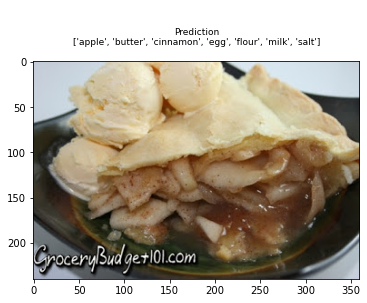

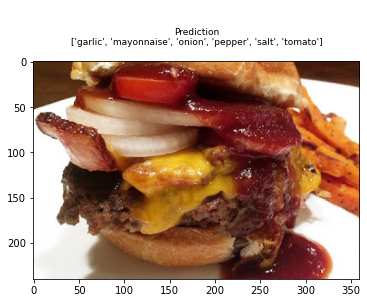

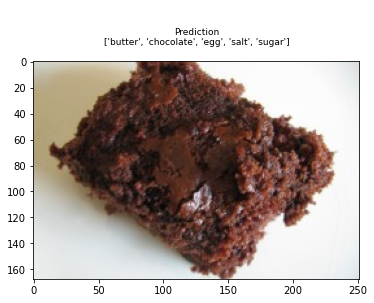

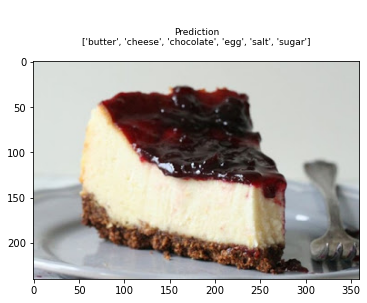

In [42]:
for index in [0, 100, 200, 300]:
    show_prediction(index, validation_df, model)

In [33]:
# Read and prepare image
img_path = "C:\\Users\\yakiy\Documents\\GoRecipeFoodRecognition\\data\\pasta.jpeg"
img = image.load_img(img_path, target_size=(*IMG_SIZE, CHANNELS))
img = image.img_to_array(img)
img = img/255
img = np.expand_dims(img, axis=0)

# Generate prediction
prediction = (model.predict(img) > 0.5).astype('int')
prediction = pd.Series(prediction[0])
prediction.index = labels
prediction = prediction[prediction==1].index.values

# Dispaly image with prediction
plt.figure(figsize=(8,4))
plt.imshow(Image.open(img_path))
plt.title('\n\nPrediction\n{}\n'.format(list(prediction)), fontsize=9)
plt.show()

RuntimeError: In draw_glyphs_to_bitmap: Could not convert glyph to bitmap (error code 0x62)

<Figure size 576x288 with 1 Axes>

In [35]:
model.save('../models/GoRecipeEngine')


INFO:tensorflow:Assets written to: ../models/GoRecipeEngine\assets


INFO:tensorflow:Assets written to: ../models/GoRecipeEngine\assets
